## Predict used cars prices for Dynamic Pricing 

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

In [69]:
cars = pd.read_csv("car data.csv")

cars['car_age'] = 2025 - cars['Year'] 
print(len(cars))
cars.head()

301


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,car_age
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,11
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,12
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,8
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,14
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,11


### EDA

**Car_Name**  
**301** total entries.  
**98** unique categories representing a wide variety of vehicles, including cars (*ritz, swift, city*) and motorcycles (*Royal Enfield Classic 350, Bajaj Pulsar 150*, etc.).  
This high cardinality suggests that **Car_Name** is highly detailed and could benefit from **grouping** (e.g., by brand or type) to reduce complexity for modeling.

---

**Year**  
**16** unique categories ranging from **2003** to **2018**.  
The spread of years shows that the dataset captures vehicles over a **15-year production range**, allowing analysis of **vehicle age** impact on selling price.

---

**Fuel_Type**  
**3** unique categories: *Petrol*, *Diesel*, and *CNG*.  
Petrol and Diesel dominate the used car market, with CNG vehicles appearing less frequently, possibly due to regional availability.

---

**Seller_Type**  
**2** unique categories: *Dealer* and *Individual*.  
This split allows examination of **pricing patterns** between professional sellers and private owners.

---

**Transmission**  
**2** unique categories: *Manual* and *Automatic*.  
Manual transmission vehicles appear more frequently, reflecting market trends, but automatic vehicles could command **higher selling prices** due to buyer preferences, especially in urban areas.


In [42]:
categorical_cols = ['Car_Name', 'Year', 'Fuel_Type', 'Seller_Type', 'Transmission']

cars[categorical_cols].nunique()

Car_Name        98
Year            16
Fuel_Type        3
Seller_Type      2
Transmission     2
dtype: int64

In [43]:
for col in categorical_cols:
    print(f"{col}: {cars[col].unique()}")

Car_Name: ['ritz' 'sx4' 'ciaz' 'wagon r' 'swift' 'vitara brezza' 's cross'
 'alto 800' 'ertiga' 'dzire' 'alto k10' 'ignis' '800' 'baleno' 'omni'
 'fortuner' 'innova' 'corolla altis' 'etios cross' 'etios g' 'etios liva'
 'corolla' 'etios gd' 'camry' 'land cruiser' 'Royal Enfield Thunder 500'
 'UM Renegade Mojave' 'KTM RC200' 'Bajaj Dominar 400'
 'Royal Enfield Classic 350' 'KTM RC390' 'Hyosung GT250R'
 'Royal Enfield Thunder 350' 'KTM 390 Duke ' 'Mahindra Mojo XT300'
 'Bajaj Pulsar RS200' 'Royal Enfield Bullet 350'
 'Royal Enfield Classic 500' 'Bajaj Avenger 220' 'Bajaj Avenger 150'
 'Honda CB Hornet 160R' 'Yamaha FZ S V 2.0' 'Yamaha FZ 16'
 'TVS Apache RTR 160' 'Bajaj Pulsar 150' 'Honda CBR 150' 'Hero Extreme'
 'Bajaj Avenger 220 dtsi' 'Bajaj Avenger 150 street' 'Yamaha FZ  v 2.0'
 'Bajaj Pulsar  NS 200' 'Bajaj Pulsar 220 F' 'TVS Apache RTR 180'
 'Hero Passion X pro' 'Bajaj Pulsar NS 200' 'Yamaha Fazer '
 'Honda Activa 4G' 'TVS Sport ' 'Honda Dream Yuga '
 'Bajaj Avenger Street 220' 'H

### Distribution of every numerical column

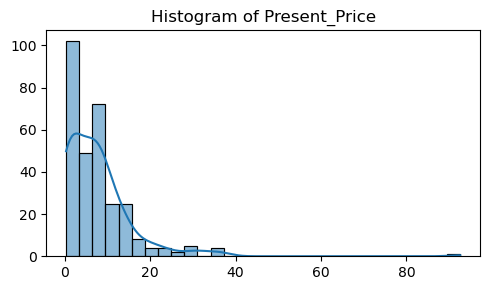

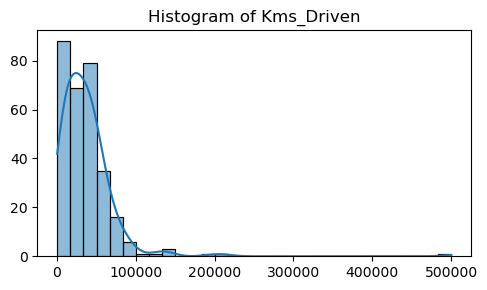

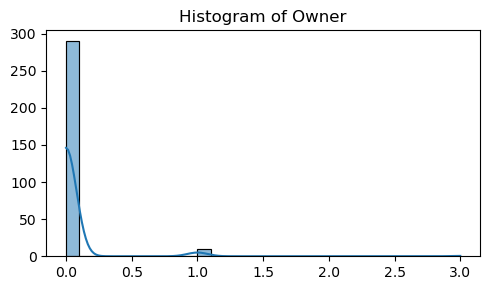

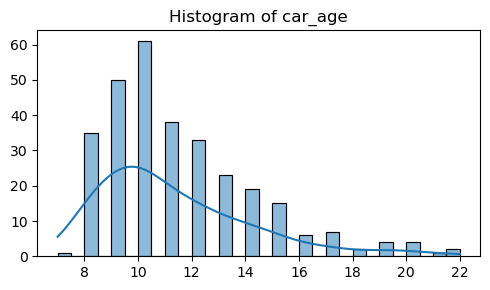

In [ ]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.histplot(X[col], bins=30, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

### The plot below shows how automatic cars prices growed from 2012

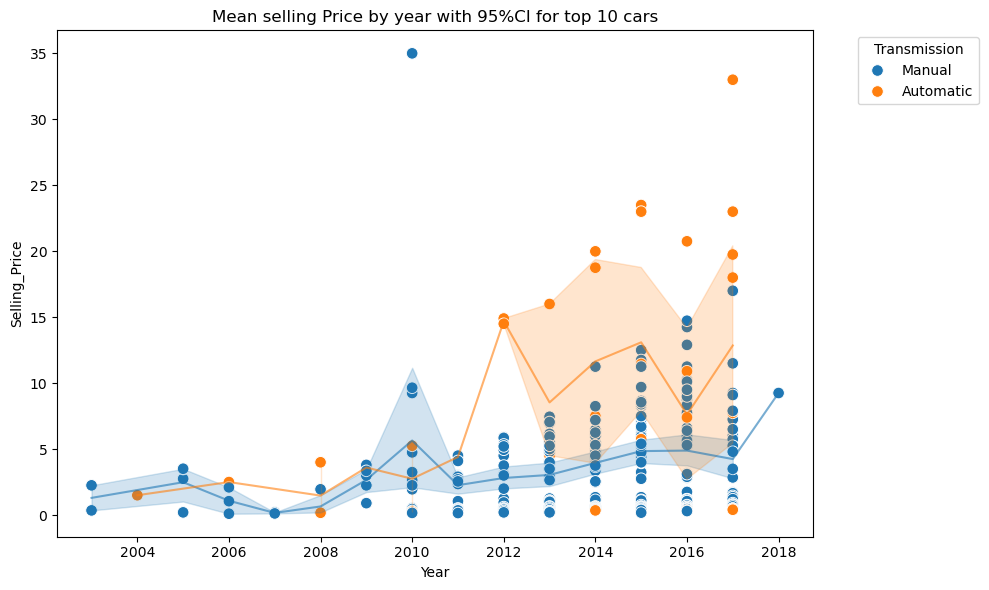

In [ ]:
filtered_cars = cars

plt.figure(figsize=(10,6))
sns.scatterplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Transmission', palette='tab10', s=70)
sns.lineplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Transmission', palette='tab10', legend=False, alpha=0.6)

plt.title('Selling Price by year with 95%CI for Transmission')
plt.legend(title='Transmission', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

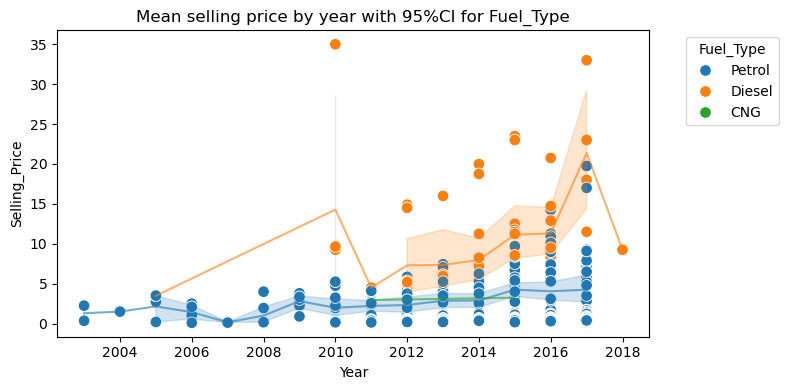

In [60]:
filtered_cars = cars

plt.figure(figsize=(8,4))
sns.scatterplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Fuel_Type', palette='tab10', s=70)
sns.lineplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Fuel_Type', palette='tab10', legend=False, alpha=0.6)

plt.title('Selling price by year with 95%CI for Fuel_Type')
plt.legend(title='Fuel_Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

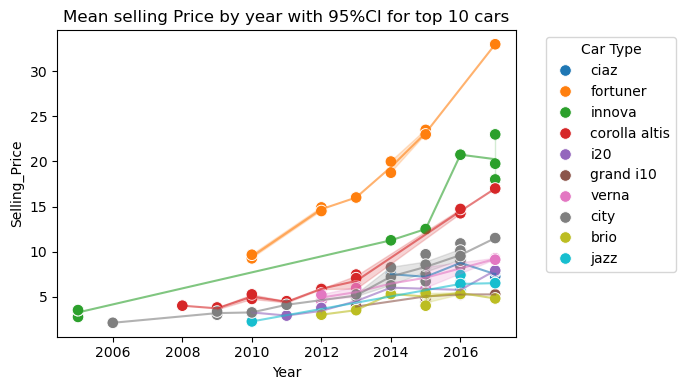

In [58]:
# top 10 most common cars in a dataset
top_cars = cars['Car_Name'].value_counts().nlargest(10).index.tolist()

filtered_cars = cars[cars['Car_Name'].isin(top_cars)]

plt.figure(figsize=(7,4))
sns.scatterplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Car_Name', palette='tab10', s=70)
sns.lineplot(data=filtered_cars, x='Year', y='Selling_Price', hue='Car_Name', palette='tab10', legend=False, alpha=0.6)

plt.title('Selling Price by year with 95%CI for top 10 cars')
plt.legend(title='Car Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Correlation analysis

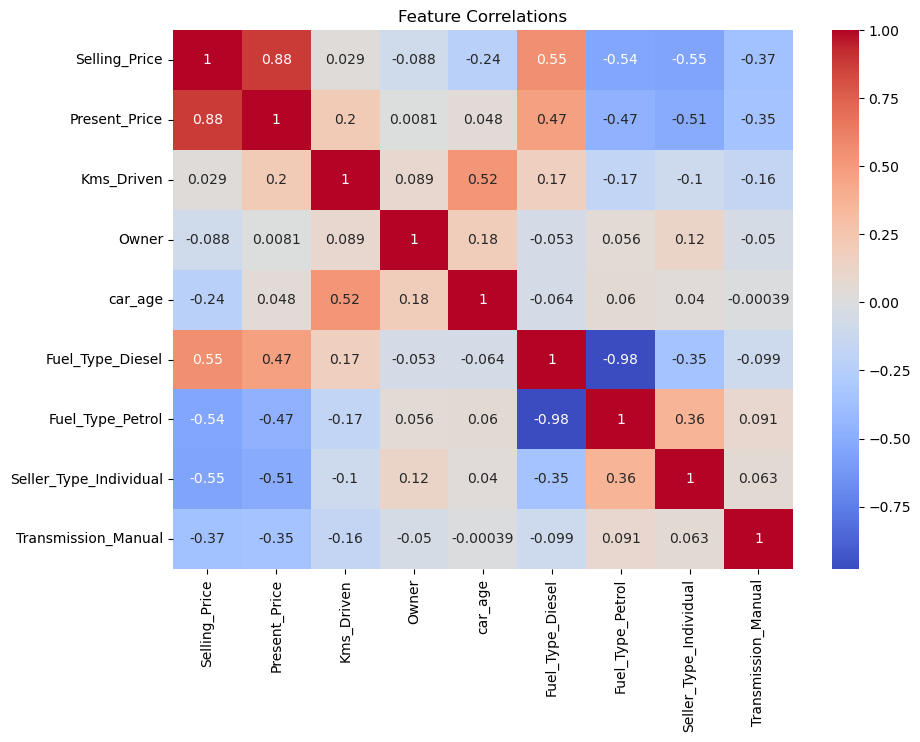

In [10]:
cars_dummies = pd.get_dummies(cars, drop_first=True)

plt.figure(figsize=(10,7))
sns.heatmap(cars_dummies.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

### Correlation matrix description

The heatmap visualizes the correlation coefficients between all numerical and one-hot encoded categorical features.

* **Selling_Price** has a strong positive correlation with **Present_Price** (**r = 0.88**), indicating that cars with higher original showroom prices tend to have higher selling prices in the used car market.
* **Fuel_Type_Diesel** shows a moderate positive correlation with **Selling_Price** (**r = 0.55**), while **Fuel_Type_Petrol** is negatively correlated (**r = -0.54**), suggesting diesel vehicles may retain more value.
* **Seller_Type_Individual** is negatively correlated with **Selling_Price** (**r = -0.55**), implying that cars sold by individuals tend to have lower prices compared to dealers.
* **car_age** and **Kms_Driven** are moderately correlated (**r = 0.52**), which is expected as older cars generally accumulate more mileage.
* There is a strong negative correlation between **Fuel_Type_Diesel** and **Fuel_Type_Petrol** (**r = -0.98**), which is an artifact of one-hot encoding (mutually exclusive categories).
* **Transmission_Manual** has a mild negative correlation with **Selling_Price** (**r = -0.37**), suggesting that automatic transmission cars might command higher resale prices.

Overall, **Present_Price**, **Fuel_Type**, and **Seller_Type** are among the strongest predictors of **Selling_Price**, supporting their inclusion in the machine learning models.


# Modelling

We are gonna build several ML models: 
- Linear and Regularized Models (Ridge/Lasso)
- Tree-based Models (Random Forest, Gradient Boosting)

### Model Evaluation Metrics

Since our target variable is a **continuous** numeric variable, we are solving a **regression** problem.  

**1. Mean Absolute Error (MAE)**
- It tells, on average, how many price units we are off.  

**2. Root Mean Squared Error (RMSE)**

* tells how wrong (in price units) the predictions are, penalizes big errors.


**3. R-squared (R² Score)**
- To see how well the model fits the data.


### Train-test split

In [70]:
X = cars.drop('Selling_Price', axis=1)
y = cars['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Features preparation
    
For categorical features -> **One-Hot Encoding** 

For numerical features -> **Standard Scaling**


- **Regression models**

Need scaling and encoding

- **Tree-based models**

Do not need scaling but Need encoding


In [ ]:
cars = cars.drop(columns=['Year', 'Car_Name'])
categorical_features = cars.select_dtypes(include='object').columns.tolist()
numerical_features = cars.select_dtypes(include=['int64', 'float64']).drop('Selling_Price', axis=1).columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [79]:
# 1. Ridge
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

# 2. Lasso
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# 3. Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# 4. XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# 5. Linear Regression baseline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [ ]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [80]:
ridge_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Present_Price',
                                                   'Kms_Driven', 'Owner',
                                                   'car_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Fuel_Type', 'Seller_Type',
                                                   'Transmission'])])),
                ('model', LinearRegression())])

In [81]:
ridge_preds = ridge_pipeline.predict(X_test)
lasso_preds = lasso_pipeline.predict(X_test)
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)
lr_preds = lr_pipeline.predict(X_test)

In [82]:
results = {}

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

evaluate_model('Ridge', y_test, ridge_preds)
evaluate_model('Lasso', y_test, lasso_preds)
evaluate_model('Random Forest', y_test, rf_preds)
evaluate_model('XGBoost', y_test, xgb_preds)
evaluate_model('Linear Regression', y_test, lr_preds)

### Baseline Models

- Tree-based models perform much better

In [83]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='RMSE')
results_df

                        MAE      RMSE        R2
Random Forest      0.609448  0.936862  0.961898
XGBoost            0.595706  0.995626  0.956968
Linear Regression  1.216226  1.865155  0.848981
Ridge              1.215796  1.866757  0.848722
Lasso              1.983445  2.745989  0.672661


Proceeding with

* **Random Forest Regressor**
* **XGBoost Regressor**


### **RandomizedSearchCV** tuning

- Using 5-fold cross-validation to avoid overfitting during tuning.

In [91]:
rf_param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [None, 5, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}


rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_grid,
    n_iter=20, 
    cv=5, 
    scoring='neg_root_mean_squared_error',  # RMSE
    random_state=42,
    verbose=1
)


rf_random_search.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_random_search.best_params_)
print("Best Random Forest RMSE:", -rf_random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest parameters: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None}
Best Random Forest RMSE: 2.0101932930688458


In [ ]:
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)

In [97]:
tuned_results = {
    'Model': ['Random Forest', 'XGBoost'],
    'Best RMSE': [-rf_random_search.best_score_, -xgb_random_search.best_score_]
}


pd.DataFrame(tuned_results)

,Model,Best RMSE
0,Random Forest,2.010193
1,XGBoost,1.229326


### Model selection
Staying with **RMSE** instead of **MAE** because pricing mistakes are very costly, it penalises very expensive/cheap cars more.

**XGBoost Regressor** has lower RMSE (**1.229**) than Random Forest.

So, we can predict used car selling prices with an average error of approximately 1230$.

### Features
- Which features mattered most for the final tuned XGBoost model

Text(0.5, 1.0, 'Top 20 Feature Importances (Tuned XGBoost Model)')

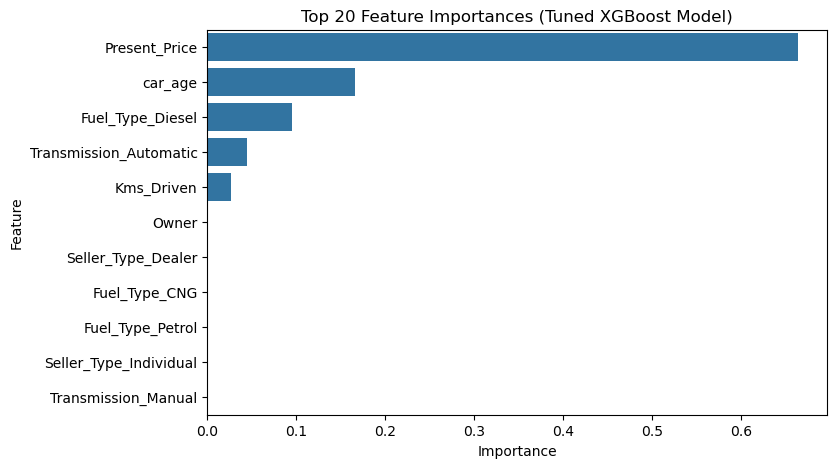

In [101]:
best_xgb_model = xgb_random_search.best_estimator_
onehot_columns = best_xgb_model.named_steps['preprocessor'].transformers_[1][1]\
    .named_steps['onehot'].get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numerical_features, onehot_columns])
importances = best_xgb_model.named_steps['model'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (Tuned XGBoost Model)')

Text(0.5, 1.0, 'Predicted vs Actual Selling Prices')

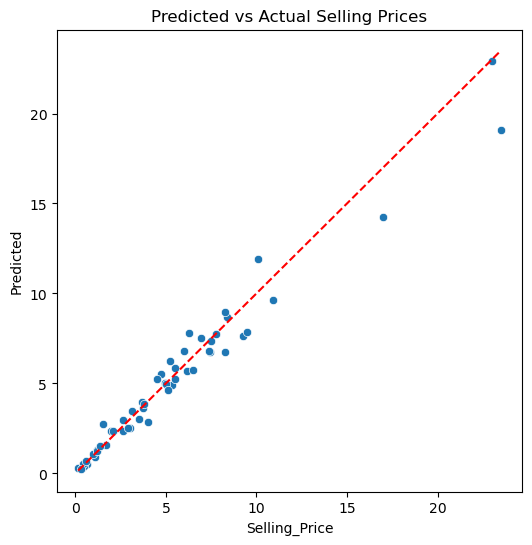

In [105]:
y_pred = best_xgb_model.predict(X_test)

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Selling Prices')

- Most of the points are very close to the red dashed line which is good. For most cars, the predicted price is very close to the actual price.

- A few points for expensive cars, for very expensive cars, the model might have slightly larger errors.

In [ ]:
joblib.dump(best_xgb_model, "final_xgb_pipeline.pkl")

This model could be deployed via FastAPI or a cloud function to a web's backend for real-time pricing